In [19]:
import wandb
from wandb.keras import WandbCallback
from emojihunt import *
import tensorflow as tf
import keras
from keras import callbacks
from keras.models import Sequential, load_model
from keras.layers import Activation, LeakyReLU, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, Concatenate, UpSampling2D, Conv2DTranspose
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import Sequence
import json
import os
from skimage.segmentation import slic, mark_boundaries, clear_border, find_boundaries
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs:", len(gpu_devices))
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

Num GPUs: 1


Create our own emojihunt object that returns a segmentation mask with each image

In [20]:
class SegEmojiHunt(EmojiHunt):
    def generate_image_and_points(self):
        '''
        Returns a target image, emoji example (uncorrupted), and ground truth gt_points. For your testing and development
        '''
        emoji_target = self.get_random_emoji_img()
        test_image   = self.get_background()

        gt_points = []
        mask = np.zeros(test_image.shape[:-1], dtype=bool)
        tmp_mask = np.zeros_like(mask)
        for _ in range(random.randint(1,10)):
            x = random.randint(0,512-self.emoji_size-1)
            y = random.randint(0,512-self.emoji_size-1)
            gt_points.append((x+self.emoji_size//2,y+self.emoji_size//2))
            augmented_emoji = self.augment_emoji(emoji_target)
            emoji_mask = np.sum(augmented_emoji,axis=-1) > 25
            
            # Compare the intersection of the new mask and the previous mask. If there's any overlap then we trace a line of zeros around the edge of the intersection
            tmp_mask[:,:] = 0
            # tmp_mask[x:x+self.emoji_size,y:y+self.emoji_size] = np.where(
            #         np.sum(augmented_emoji,axis=-1) > 25, emoji_mask, mask[x:x+self.emoji_size,y:y+self.emoji_size])
            tmp_mask[x:x+self.emoji_size,y:y+self.emoji_size] = emoji_mask
            intersection = np.logical_and(tmp_mask, mask)
            if np.any(intersection):
                mask[x:x+self.emoji_size,y:y+self.emoji_size] = np.where(
                    np.sum(augmented_emoji,axis=-1) > 25, emoji_mask, mask[x:x+self.emoji_size,y:y+self.emoji_size])
                # Find the contour of the intersection
                contour = find_boundaries(tmp_mask, mode='thick')
                # Expand the contour by 1 pixel
                # contour = np.logical_and(contour, np.logical_not(intersection))
                
                # Trace a line of zeros around the contour
                mask[contour] = 0

            else:
                mask[x:x+self.emoji_size,y:y+self.emoji_size] = np.where(
                    np.sum(augmented_emoji,axis=-1) > 25, emoji_mask, mask[x:x+self.emoji_size,y:y+self.emoji_size])
            
            test_image[x:x+self.emoji_size,y:y+self.emoji_size] = np.where(
                np.expand_dims(np.sum(augmented_emoji,axis=-1) > 25,-1), augmented_emoji, test_image[x:x+self.emoji_size,y:y+self.emoji_size])
        
        test_image_agus = [iaa.AdditiveGaussianNoise(scale=(0, 0.1*255)),
                            iaa.GaussianBlur(sigma=(0.0, 0.25))]

        test_image = iaa.Sequential(test_image_agus)(image=test_image)

        return test_image, emoji_target, gt_points, mask

Basic hyperparameters

In [21]:
batch_size = 8
lr = 0.0001
img_width = img_height = 256

if keras.backend.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)


Data Generator to feed the model. Resizes the input image, converts it to LAB, and normalizes it to [-1, 1]

In [22]:
class DataGenerator(keras.utils.Sequence):
    emoji_hunt_object = SegEmojiHunt()

    def __init__(self, batch_size, augment, num_batches=100):
        self.batch_size = batch_size
        self.augment = augment
        self.num_batches = num_batches
        self.datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input)

    def __len__(self):
        return batch_size*self.num_batches

    def __getitem__(self, idx):
        'Generate one batch of data'
        X = np.empty((self.batch_size, *input_shape), dtype=np.uint8)
        Y = np.zeros((self.batch_size, img_width, img_height), dtype=np.uint8)
        for i in range(self.batch_size):
            target_image, emoji, ground_truth, mask = self.emoji_hunt_object.generate_image_and_points()
            # Convert to RGB and resize
            target_image = cv2.resize(target_image, (img_width, img_height), interpolation=cv2.INTER_AREA)
            mask = cv2.resize(mask.astype('uint8'), (img_width, img_height), interpolation=cv2.INTER_NEAREST)
            target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2LAB)

            # If one segment in the mask contains 2+ ground truth points split the segment into 2 by inserting a line of zeros
            # Check each segment
            # for region in regionprops(label(mask)):
            #     # Check each ground truth point
            #     count = 0
            #     matched_points = []
            #     for point in ground_truth:
            #         # If the point is in the region
            #         if region.contains(point):
            #             count += 1
            #             matched_points.append(point)
            #             if count >= 2:
            #                 # Split the region
            #                 slope = 
            #                 break

            X[i,] = target_image
            Y[i] = mask

        # Normalize
        self.datagen.standardize(X)
        assert img_width == img_height
        

        return X, Y

Generate some example masks

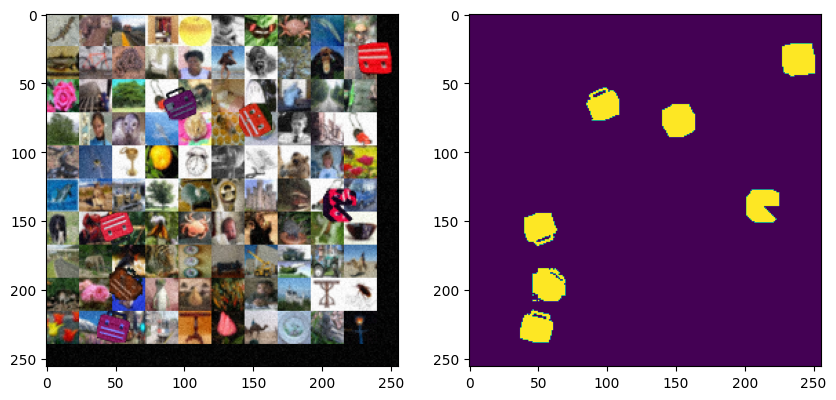

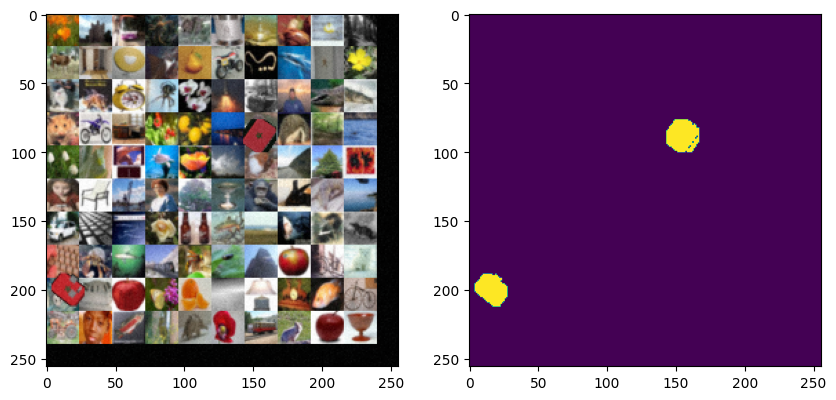

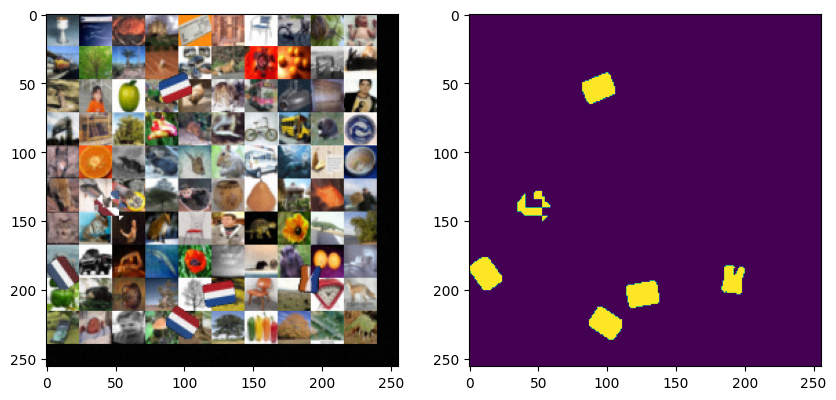

In [23]:
train_ds = DataGenerator(batch_size, augment=False, num_batches=150)
val_ds = DataGenerator(batch_size, augment=False, num_batches=20) # Only used for scoring, not super useful

batch = train_ds[0]
for i in range(3):
    plt.figure(figsize=(10,10))
    ax = plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(batch[0][i], cv2.COLOR_LAB2RGB))
    plt.subplot(1, 2, 2, sharex=ax, sharey=ax)
    plt.imshow(batch[1][i])
    plt.show()

Setup for weights and biases logging (optional)

In [24]:
wandb.init(
    # set the wandb project where this run will be logged
    project="emoji-hunt",

    # track hyperparameters and run metadata with wandb.config
    config={
        "batch_size": batch_size
    }
)

# def wandb_point_and_mask(image, pred_point, true_point, pred_mask, true_mask):
#     return wandb.Image(image, boxes={
#         "predictions": {
#             "box_data": [{
#                 "position": {
#                     "minX": pred_point[0],
#                     "maxX": pred_point[0],
#                     "minY": pred_point[1],
#                     "maxY": pred_point[1]
#                     },
#             }],
#         },
#         "ground_truth": {
#             "box_data": [{
#                 "position": {
#                     "minX": true_point[0],
#                     "maxX": true_point[0],
#                     "minY": true_point[1],
#                     "maxY": true_point[1]
#                     },
#             }],
#         }
#     },
#     masks={
#         "predictions": {
#             "mask_data": pred_mask
#         },
#         "ground_truth": {
#             "mask_data": true_mask
#         }
#     })

# class PointMaskLogger(tf.keras.callbacks.Callback):
#     def __init__(self):
#         super(PointMaskLogger, self).__init__()
#         self.val_images, mask_and_point = next(iter(val_ds))
#         self.true_maskss = mask_and_point[0]
#         self.true_points = []
#         for j, (x,y) in enumerate(mask_and_point[1]):
#             self.true_points.append((x, y))


#     def on_epoch_end(self, logs, epoch):
#         localization_list = []

#         for idx in range(len(self.val_images)):
#             # get image
#             image = self.val_images[idx]
#             # get ground truth mask and point coordinates.
#             true_mask = int(self.true_masks[idx].numpy())
#             true_point = self.true_points[idx]
#             # get model prediction.
#             pred_label, p_bbox = model.predict(np.expand_dims(image, 0))
#             # get argmax of the prediction
#             pred_label = int(np.argmax(pred_label[0])) 
#             # get wandb image
#             localization_list.append(wandb_bbox(image, 
#                                                 p_bbox[0].tolist(),
#                                                 pred_label, 
#                                                 t_bbox.numpy().tolist(), 
#                                                 true_label, 
#                                                 class_id_to_label))


#         wandb.log({"predictions" : localization_list})



acc,▁
epoch,▁
loss,▁
lr,▁
acc,0.99662
epoch,0
loss,0.00886
lr,0.0


https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/ for the U-Net architecture

In [25]:
def double_conv_block(x, n_filters):
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = MaxPooling2D()(f)
   p = Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   x = Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = Concatenate(axis=-1)([x, conv_features])
   x = Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)
   return x

In [26]:
if os.path.exists('model.h5'):
    model = load_model('model.h5')
else:
    in1 = keras.Input(shape=input_shape)

    # encoder: contracting path - downsample
    f1, p1 = downsample_block(in1, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    # Bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding path - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)
    # outputs
    output_mask = Conv2D(2, 1, padding="same", activation = "softmax")(u9)

    model = keras.Model(in1, output_mask, name="U-Net")

    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(learning_rate=lr),
                metrics='acc')
    
    model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [27]:
early_stopping = callbacks.EarlyStopping(monitor='loss', patience=4, restore_best_weights=True, start_from_epoch=5)
tensorboard = callbacks.TensorBoard(log_dir=f'./logs/run{np.random.randint(1,1000)}', histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=5)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=1, min_lr=0.000001, min_delta=0.0003)
checkpoint = callbacks.ModelCheckpoint(f'./model.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
model.fit(train_ds,
        batch_size=batch_size,
        epochs=70,
        callbacks=[early_stopping, reduce_lr, checkpoint, WandbCallback(input_type="image", log_weights=True, save_model=True)],
        # callbacks=[early_stopping, reduce_lr, checkpoint],
        use_multiprocessing=True,
        workers=90)

Epoch 1/70


2023-03-16 19:59:33.236225: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1200/1200 [==============================] - ETA: 0s - loss: 0.2663 - acc: 0.9687

wandb: WARNING No validation_data set, pass a generator to the callback.


1200/1200 [==============================] - 223s 180ms/step - loss: 0.2663 - acc: 0.9687 - lr: 1.0000e-04
Epoch 2/70
1200/1200 [==============================] - ETA: 0s - loss: 0.0404 - acc: 0.9855

wandb: WARNING No validation_data set, pass a generator to the callback.


1200/1200 [==============================] - 219s 180ms/step - loss: 0.0404 - acc: 0.9855 - lr: 1.0000e-04
Epoch 3/70
1200/1200 [==============================] - ETA: 0s - loss: 0.0249 - acc: 0.9909

wandb: WARNING No validation_data set, pass a generator to the callback.


1200/1200 [==============================] - 218s 179ms/step - loss: 0.0249 - acc: 0.9909 - lr: 1.0000e-04
Epoch 4/70
1200/1200 [==============================] - ETA: 0s - loss: 0.0200 - acc: 0.9927

wandb: WARNING No validation_data set, pass a generator to the callback.


1200/1200 [==============================] - 222s 182ms/step - loss: 0.0200 - acc: 0.9927 - lr: 1.0000e-04
Epoch 5/70
1200/1200 [==============================] - ETA: 0s - loss: 0.0172 - acc: 0.9937

wandb: WARNING No validation_data set, pass a generator to the callback.


1200/1200 [==============================] - 223s 184ms/step - loss: 0.0172 - acc: 0.9937 - lr: 1.0000e-04
Epoch 6/70
1200/1200 [==============================] - ETA: 0s - loss: 0.0151 - acc: 0.9944

wandb: WARNING No validation_data set, pass a generator to the callback.


1200/1200 [==============================] - 224s 184ms/step - loss: 0.0151 - acc: 0.9944 - lr: 1.0000e-04
Epoch 7/70
1200/1200 [==============================] - ETA: 0s - loss: 0.0139 - acc: 0.9949

wandb: WARNING No validation_data set, pass a generator to the callback.


1200/1200 [==============================] - 223s 183ms/step - loss: 0.0139 - acc: 0.9949 - lr: 1.0000e-04
Epoch 8/70
1200/1200 [==============================] - ETA: 0s - loss: 0.0129 - acc: 0.9952

wandb: WARNING No validation_data set, pass a generator to the callback.


1200/1200 [==============================] - ETA: 0s - loss: 0.0119 - acc: 0.9956

wandb: WARNING No validation_data set, pass a generator to the callback.


1200/1200 [==============================] - 244s 200ms/step - loss: 0.0119 - acc: 0.9956 - lr: 1.0000e-04
Epoch 10/70
1200/1200 [==============================] - ETA: 0s - loss: 0.0113 - acc: 0.9958

wandb: WARNING No validation_data set, pass a generator to the callback.


1200/1200 [==============================] - 237s 195ms/step - loss: 0.0113 - acc: 0.9958 - lr: 1.0000e-04
Epoch 11/70
1200/1200 [==============================] - ETA: 0s - loss: 0.0108 - acc: 0.9960

wandb: WARNING No validation_data set, pass a generator to the callback.


1200/1200 [==============================] - 236s 194ms/step - loss: 0.0108 - acc: 0.9960 - lr: 1.0000e-04
Epoch 12/70
1200/1200 [==============================] - ETA: 0s - loss: 0.0101 - acc: 0.9963

wandb: WARNING No validation_data set, pass a generator to the callback.


1200/1200 [==============================] - 223s 183ms/step - loss: 0.0101 - acc: 0.9963 - lr: 1.0000e-04
Epoch 13/70
1200/1200 [==============================] - ETA: 0s - loss: 0.0097 - acc: 0.9964

wandb: WARNING No validation_data set, pass a generator to the callback.


1200/1200 [==============================] - 220s 181ms/step - loss: 0.0097 - acc: 0.9964 - lr: 1.0000e-04
Epoch 14/70
1200/1200 [==============================] - ETA: 0s - loss: 0.0092 - acc: 0.9966

wandb: WARNING No validation_data set, pass a generator to the callback.


1200/1200 [==============================] - 227s 186ms/step - loss: 0.0092 - acc: 0.9966 - lr: 1.0000e-04
Epoch 15/70
1200/1200 [==============================] - ETA: 0s - loss: 0.0089 - acc: 0.9967

wandb: WARNING No validation_data set, pass a generator to the callback.


1200/1200 [==============================] - 225s 185ms/step - loss: 0.0089 - acc: 0.9967 - lr: 1.0000e-04
Epoch 16/70
1200/1200 [==============================] - ETA: 0s - loss: 0.0085 - acc: 0.9968

wandb: WARNING No validation_data set, pass a generator to the callback.


1200/1200 [==============================] - 212s 174ms/step - loss: 0.0085 - acc: 0.9968 - lr: 1.0000e-04
Epoch 17/70
1200/1200 [==============================] - ETA: 0s - loss: 0.0085 - acc: 0.9969

wandb: WARNING No validation_data set, pass a generator to the callback.


1200/1200 [==============================] - 214s 175ms/step - loss: 0.0085 - acc: 0.9969 - lr: 1.0000e-04
Epoch 18/70
1200/1200 [==============================] - ETA: 0s - loss: 0.0075 - acc: 0.9972

wandb: WARNING No validation_data set, pass a generator to the callback.


1200/1200 [==============================] - 220s 181ms/step - loss: 0.0075 - acc: 0.9972 - lr: 2.0000e-05
Epoch 19/70
1200/1200 [==============================] - ETA: 0s - loss: 0.0073 - acc: 0.9972

wandb: WARNING No validation_data set, pass a generator to the callback.


1200/1200 [==============================] - 220s 181ms/step - loss: 0.0073 - acc: 0.9972 - lr: 2.0000e-05
Epoch 20/70
1200/1200 [==============================] - ETA: 0s - loss: 0.0072 - acc: 0.9972

wandb: WARNING No validation_data set, pass a generator to the callback.


1200/1200 [==============================] - 222s 182ms/step - loss: 0.0072 - acc: 0.9972 - lr: 4.0000e-06
Epoch 21/70
1200/1200 [==============================] - ETA: 0s - loss: 0.0071 - acc: 0.9973

wandb: WARNING No validation_data set, pass a generator to the callback.


1200/1200 [==============================] - 227s 187ms/step - loss: 0.0071 - acc: 0.9973 - lr: 1.0000e-06
Epoch 22/70
1200/1200 [==============================] - ETA: 0s - loss: 0.0072 - acc: 0.9972

wandb: WARNING No validation_data set, pass a generator to the callback.


1200/1200 [==============================] - 228s 187ms/step - loss: 0.0072 - acc: 0.9972 - lr: 1.0000e-06
Epoch 23/70
 165/1200 [===>..........................] - ETA: 3:19 - loss: 0.0072 - acc: 0.9972

KeyboardInterrupt: 

## Results
Unet mask -> remove small clusters = ~50 score  
Unet mask with 0s between touching emojis -> remove small clusters = ~

# Some Visualizations

1/1 [==============================] - 0s 40ms/step


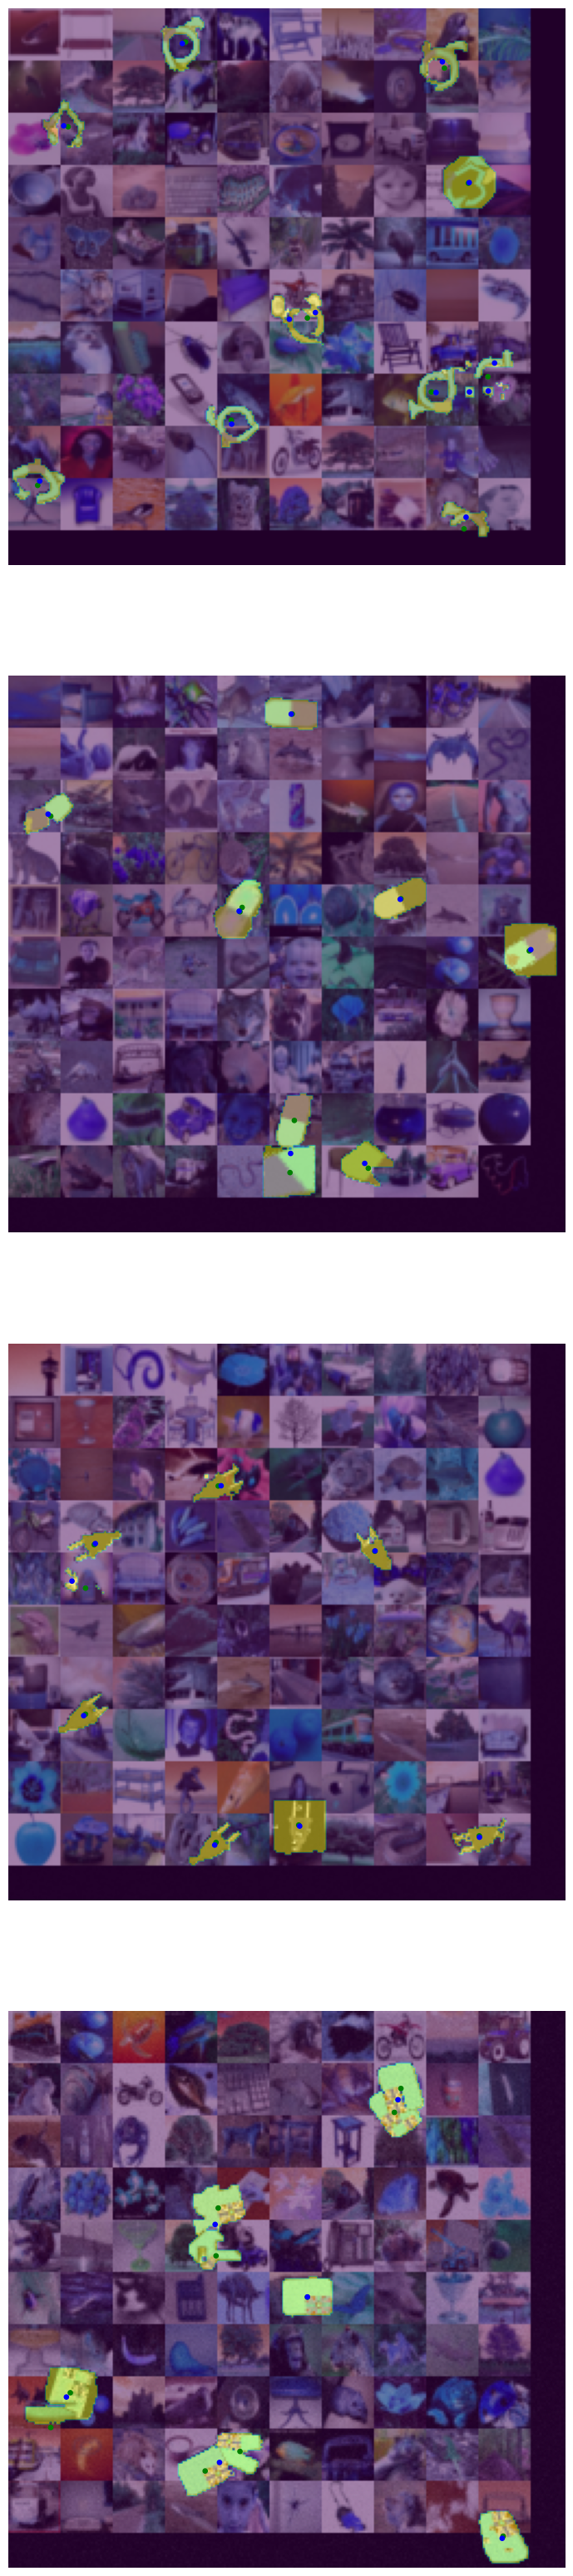

In [30]:
samples = [val_ds.emoji_hunt_object.generate_image_and_points() for _ in range(batch_size//2)]

sample_imgs = [sample[0] for sample in samples]
sample_emojis = [sample[1] for sample in samples]
sample_ground_truth = [sample[2] for sample in samples]

inputs = np.empty((batch_size//2, *input_shape))
for i, image in enumerate(sample_imgs):
    image = cv2.resize(image, (img_width, img_height), interpolation=cv2.INTER_AREA)
    sample_imgs[i] = image # For displaying in human-viewable form
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    val_ds.datagen.standardize(image)
    inputs[i] = image

preds = model.predict(inputs, batch_size=batch_size//2)
pred_masks = np.argmax(preds, axis=-1)
pred_coords = preds[1]
# Plot 4 results, print the image and mask seperately
fig, axs = plt.subplots(4, 1, figsize=(30, 40))
for i, (img, pred, emoji) in enumerate(zip(sample_imgs, pred_masks, sample_emojis)):
    if i >= 4:
        break
    ax = axs[i]
    ax.imshow(img)
    ax.imshow(pred, alpha=0.5)
    ax.axis('off')
    for y, x in sample_ground_truth[i]:
         ax.add_patch(plt.Circle((x//2, y//2), 1, color='g', fill=True))

    segments = regionprops(label(pred_masks[i]))
    ret_coords = []
    for props in segments:
        if props.area < 20:
            continue
        cx, cy = props.centroid  # centroid coordinates
        v = props.label
        # print(f'Emoji {v} at ({cx}, {cy})')
        ax.add_patch(plt.Circle((cy, cx), 1, color='b', fill=True))


# Score the model

In [32]:
# TODO: IOU metric
def test_good_function(image, _):
    image = cv2.resize(image, (img_width, img_height), interpolation=cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    val_ds.datagen.standardize(image)
    preds = model.predict(np.array([image]), batch_size=1, verbose=0)
    pred_masks = np.argmax(preds, axis=-1)

    # Cluster regions of 1s
    segments = regionprops(label(pred_masks[0]))
    ret_coords = []
    for props in segments:
        if props.area < 20:
            continue
        cx, cy = props.centroid  # centroid coordinates
        v = props.label
        # print(f'Emoji {v} at ({cx}, {cy})')
        ret_coords.append((int(cx*2), int(cy*2)))

    # fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    # ax.imshow(pred_masks[0])
    return ret_coords

# test_good_function(*val_ds.emoji_hunt_object.generate_image_and_points())
emoji_hunt_object = EmojiHunt() 
config = emoji_hunt_object.get_config()
config['emoji_transforms']['DirectedEdgeDetect'] = False
config['emoji_transforms']['ChangeColorTemperature'] = False
config['emoji_transforms']['PiecewiseAffine'] = False
emoji_hunt_object.update_config(config)
emoji_hunt_object.offical_test(test_good_function,emoji_hunt_object.get_config())
    

~~~~~STARTING TEST~~~~~~
Enabled Augmentations....
     Add
     Multiply
     Cutout
     CoarseDropout
     CoarseSaltAndPepper
     JpegCompression
     BlendAlpha
     BlendAlphaRegularGrid
     GaussianBlur
     MotionBlur
     MultiplyHueAndSaturation
     Grayscale
     SigmoidContrast
     CLAHE
     Emboss
     Fliplr
     PerspectiveTransform
     WithPolarWarping
     Rot90
     ElasticTransformation
     Jigsaw
Scores (lower is better)....
    Run 0 -> 6.324555320336759
    Run 1 -> 1.3440825170409967
    Run 2 -> 75.38246927522032
    Run 3 -> 221.27076024719136
    Run 4 -> 1.9142135623730951
    Run 5 -> 103.96963839251666
    Run 6 -> 118.06195954566637
    Run 7 -> 5.925555077809721
    Run 8 -> 1.2761423749153966
    Run 9 -> 60.10039116157989
    Run 10 -> 2.23606797749979
    Run 11 -> 1.395741732923815
    Run 12 -> 3.6034165586355513
    Run 13 -> 3.0509941483609833
    Run 14 -> 2.5623091878070197
    Run 15 -> 1.9073262114491119
    Run 16 -> 1.7527335842160128
